# Lab Assignment One: CNN Visualization

# Team Member Information:

In [32]:
import pandas as pd
names = ['Zhenxuan Ouyang','Jianmin Li']
smuid = [47784546, 47794972]
teaminfo = pd.DataFrame()
teaminfo['name'] = names
teaminfo['smu id'] = smuid
teaminfo

,name,smu id
0,Zhenxuan Ouyang,47784546
1,Jianmin Li,47794972


### 1. [10 Points] Based on the blog post above, create and argue for one reason you might use DeepDream to analyze a CNN visually. Write out this argument in text for the lab using your own words. Alternatively, you can also argue for a counter argument (that is, why this is only artistic, not useful). 

We think it'll be useful to use DeepDream to analyze CNN visually. Even though we have different CNN to classify different objects, some of them are very powerful, we still don't know why the network does that way in order to classify objects or what the network learns in order to make the final decision. In order to understand internal knowledge the network learns, we need a way such like DeepDream to analyze the network.<br>
One thing the DeepDream can tell us is when DeepDream detects something it could enhance that. It we put a picture with an aircraft which looks like a bird, then DeepDream detects it and enhance it, if we put a picture with a boat which looks like fish, then DeepDream detects it and enhance it. If we choose the higher layer that represents the complex and sophisticated features, then we can know what things the network detects and what object the network thinks it is by using DeepDream.<br>
Using DeepDream to analyze CNN, not only it shows us what part of image that the network thinks it's important, but we also know where the weakness of the network is and how to improve it. All in all, the DeepDream allows us to know more about what's going on inside the CNN network.

### 2. [10 Points] In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet). These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.). Explain the model you chose and why.

In this lab, we choose VGG16 as our neural network model that has been pre-trained on ImageNet. The VGG network architecture was introduced by Simonyan and Zisserman in their 2014 paper, "Very Deep Convolutional Networks for Large Scale Image Recognition" (Reference: https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/) The VGG network is famous for its simplicity, using 3x3 convolutional layers. It has two fully-connected layers with 4096 nodes in each layer followed by softmax classifier. 16 means VGG16 has 16 weight layers.<br>
The main reason why we choose VGG16 is because of its simplicity compared to other network. It has 23 layers compared to other networks which has more than 100 layers. Besides, the accuracy between VGG16 and other networks are only slightly different, not too much. For simply objects classification, we think there is no big difference between VGG16 and other networks.

### 3. [20 Points] Manipulate the code from the CNN visualization notebook to implement the DeepDream process. This includes:
#### Using L1 gradient normalization for gradient updates
#### Adding random shifts/resizing in the process (as described in DeepDream)
#### If using code from another source, you must heavily document the code so that I can grade your understanding of the code used. 

First we import Keras and we choose VGG16 as our pre-trained model on ImageNet dataset.

In [33]:
import keras
keras.__version__

from keras.models import load_model
from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception
from keras import backend as K
from IPython.display import clear_output

model = VGG16(weights='imagenet', include_top=False)
# model = Xception(weights='imagenet', include_top=False)
model.summary()  # As a reminder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Then we choose one picture as an input to our DeepDream network. The picture is about an aircraft with sky as its background

(1, 527, 900, 3)


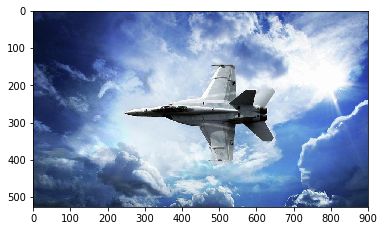

In [34]:
import copy

img_url = 'https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/f18-fighter-jet-aaron-berg.jpg'
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
# use this to install PIL: conda install --channel conda-forge pillow=5
from PIL import Image
import matplotlib.pyplot as plt

def load_preprocess_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_tensor = np.array(img).astype(float)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

img_tensor = load_preprocess_img(img_url)
print(img_tensor.shape)
img_drawing = copy.deepcopy(img_tensor)

plt.imshow(img_tensor[0])
plt.show()

Now we start implementing the DeepDream process. We defined four different functions to implement this process.<br>
1. Def resize_img: Resize the original image to specific size.<br>
2. Def deprocess_image: A function that makes image be a valid and displayable image.<br>
3. Def generate_random_size: We enter how many shirking process we want as parameter and this fuction will generate different shirking size for us acoording to the parameter we enter.<br>
4. Def generate_deepdream_random_resize: This function is the core of implementing the DeepDream process. This function takes 4 parameters: the layer name we want to visualize, number of iterations, step and how many times of shirking we want.<br>
For the specific output layer, we do:<br>
(1) Build loss function that maximize the activation of specific output layer: loss = K.mean(layer_output[:, :, :, :]) <br>
(2) Compute the gradient of the input loss: grads = K.gradients(loss, model.input)[0]<br>
(3) Normalize the gradient with L1-normalization: grads /= K.mean(K.abs(grads)) + 1e-5<br>
(4) A function that returns the loss and grads: iterate = K.function([model.input], [loss, grads])<br>
(5) Then we generate different shirking size as preparation for DeepDream<br>
For different shirking process, we do:<br>
(1) We calculate gradient ascent according to iteration number<br>
(2) Upscale the shrunk image: upscale_shrunk_img = resize_img(shrunk_original_image, theShape)<br>
(3) Calculating the lost detail: lost_diff = same_size_original - upscale_shrunk_img<br>
(4) Adding the lost detail: input_img_data += lost_diff<br>
(5) Reseting the shrunk image to current size as input to the next resize shape<br>
Above is basically how we implemented the DeepDream process.<br>
Reference: https://keras.io/examples/deep_dream/ (Keras Documentation)<br>

In [46]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import scipy
from IPython.display import clear_output
from tqdm.notebook import tqdm
import cv2

# ref: https://keras.io/examples/deep_dream/
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
                float(size[0]) / img.shape[1],
                float(size[1]) / img.shape[2],
                1)
    return scipy.ndimage.zoom(img, factors, order=1)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_random_size(img, resize_number):
    original_shape = img.shape[1:3]
    resize_list = [original_shape]
    resize_ratio = 1.5
    for i in range(resize_number):
        step_shape = tuple([int(dimension/(resize_ratio**i)) for dimension in original_shape])
        resize_list.append(step_shape)
    resize_list = resize_list[::-1]
    
    return resize_list


def generate_deepdream_random_resize(layer_name, iteration_number, step, resize_number):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, :])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient with L1-normalization
    grads /= K.mean(K.abs(grads)) + 1e-5

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = copy.deepcopy(img_drawing)
    
    iteration_img_list = list()
    resize_iteration_list = list()
    
    resize_list = generate_random_size(input_img_data, resize_number)
    shrunk_original_image = resize_img(input_img_data, resize_list[0])
    
    for theShape in resize_list:
        
        input_img_data = resize_img(input_img_data, theShape)
        # gradient ascent
        for i in tqdm(range(iteration_number)):
            
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
            iteration_img_list.append(deprocess_image(input_img_data[0]))
        
        # upscale the shrunk image
        upscale_shrunk_img = resize_img(shrunk_original_image, theShape)
        # resize the original image into the same size
        same_size_original = resize_img(img_drawing, theShape)
        # calculate the lost detail
        lost_diff = same_size_original - upscale_shrunk_img
        # add the lost detail
        input_img_data += lost_diff
#         input_img_data += (lost_diff + 3 * np.random.normal(0, 1, input_img_data.shape))
        # reset the shrunk image to current size as input to the next resize shape
        shrunk_original_image = resize_img(img_drawing, theShape)
        
        # save the image into list
        resize_iteration_list.append(deprocess_image(input_img_data[0]))
        

    return iteration_img_list, resize_iteration_list

### 4. [20 Points] Choose an image to seed the DeepDream visualizations and run the DeepDream process. Save out the image at various steps so that you can visualize the iterative process (a video or GIF would be a nice addition). Explain any clues that the iterative process gives for how the CNN discerns different classes, if any. 

We put our picture into DeepDream we implemented. We visualized layer "block5_conv3", we have 15 iterations, 0.05 step and 3 shrinking times.<br> 
And Then we save the image at every iteration and visualize it, now let's see what things are added into our image by DeepDream.


Wall time: 4min 12s


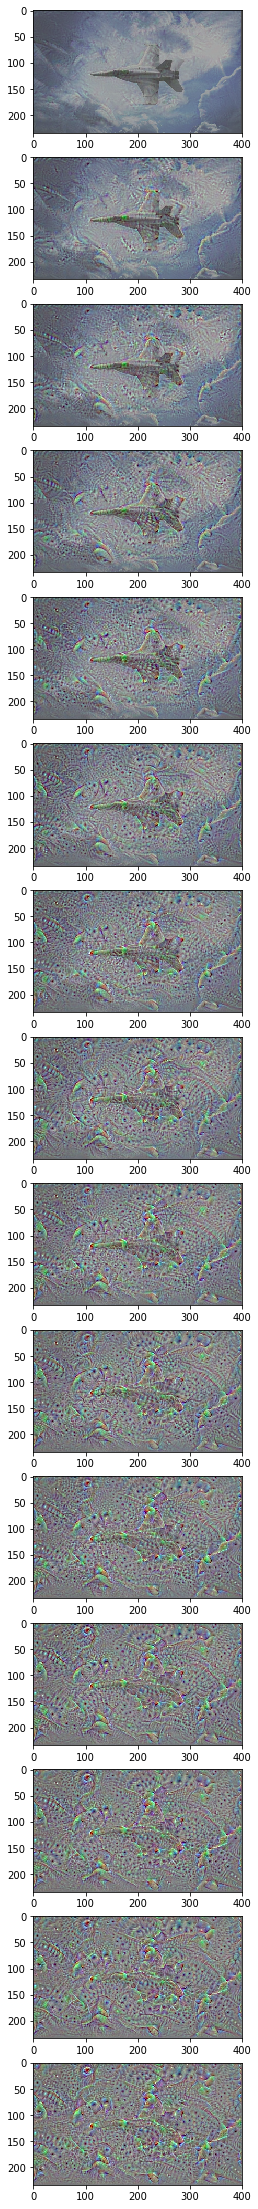

In [47]:
%%time
import glob
import cv2
import numpy as np


img_list2, resize_img_list2 = generate_deepdream_random_resize('block5_conv3', iteration_number=15, step=0.05, resize_number=3)

image_path = 'Results/Nonnoise/'

start_index = 0
end_index = 15

plt.figure(figsize=(500,40))
for i in range(start_index, end_index):
    filename = ''
    index = int(np.floor(i/10))
#     filename += 'image-' + str(chr(index+ord('a'))) + '-' + str(i%10)
    
    saved_image_filename = 'image-' + str(chr(index+ord('a'))) + '-' + str(i%10) + '.jpg'
    cv2.imwrite(image_path+saved_image_filename, img_list2[i])
    plt.subplot(end_index-start_index, 1, i-start_index+1)
    plt.imshow(img_list2[i])

We saved out image for every iteration. As we can see, the original image was an aircraft. But with the number of iterations goes up, DeepDream adds birds to it and in the last image, we can hardly find the original aircraft in the image because the aircraft becomes a bird.<br>
From above, we can see this DeepDream works and we get what we want. First, the background is about sky so we expect the DeepDream would add something that's related to sky. And the original aircraft in the image looks like a bird so we also expected the aircraft could look more like a bird after going through DeepDream.<br>

We also made a small video to show the iterative process

In [48]:
import glob
def generate_video_from_images():
    img_array = list()
    image_path = 'Results/Nonnoise/*.jpg'
    filename_array = glob.glob(image_path)
    filename_array = sorted(filename_array)
    size = tuple()
    for filename in filename_array:
        img = cv2.imread(filename)
        print(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
        
    video_path = 'Results/'
    out = cv2.VideoWriter(video_path+'deepdream.avi',cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
     
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print('done')

We saved our pictures in Results/Nonnoise/ and we also made a video to show the transformation saved at Results/

In [49]:
generate_video_from_images()

Results/Nonnoise\image-a-0.jpg
Results/Nonnoise\image-a-1.jpg
Results/Nonnoise\image-a-2.jpg
Results/Nonnoise\image-a-3.jpg
Results/Nonnoise\image-a-4.jpg
Results/Nonnoise\image-a-5.jpg
Results/Nonnoise\image-a-6.jpg
Results/Nonnoise\image-a-7.jpg
Results/Nonnoise\image-a-8.jpg
Results/Nonnoise\image-a-9.jpg
Results/Nonnoise\image-b-0.jpg
Results/Nonnoise\image-b-1.jpg
Results/Nonnoise\image-b-2.jpg
Results/Nonnoise\image-b-3.jpg
Results/Nonnoise\image-b-4.jpg
done


In [50]:
filename = ''
i = 31
index = int(np.floor(i/10))

print(index)
print(chr(index+ord('a')))
print(i%10)

3
d
1


### 5. [10 Points] Exceptional work: hypothesize another type of noise to introduce in the DeepDream process and implement it. Run the same image through as before and compare/contrast the result. 

We add gusseisen noise into every input image before conducting gradient ascent. We hope by doing that way the DeepDream can be more robust.

In [92]:
def generate_deepdream_random_resize(layer_name, iteration_number, step, resize_number):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, :])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient with L1-normalization
    grads /= K.mean(K.abs(grads)) + 1e-5

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = copy.deepcopy(img_drawing)
    
    iteration_img_list = list()
    resize_iteration_list = list()
    
    resize_list = generate_random_size(input_img_data, resize_number)
    shrunk_original_image = resize_img(input_img_data, resize_list[0])
    
    for theShape in resize_list:
        
        input_img_data = resize_img(input_img_data, theShape) + resize_img(1.0 * np.random.normal(0, 0.1, input_img_data.shape), theShape)
        # gradient ascent
        for i in tqdm(range(iteration_number)):
            
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
            iteration_img_list.append(deprocess_image(input_img_data[0]))
        
        # upscale the shrunk image
        upscale_shrunk_img = resize_img(shrunk_original_image, theShape)
        # resize the original image into the same size
        same_size_original = resize_img(img_drawing, theShape)
        # calculate the lost detail
        lost_diff = same_size_original - upscale_shrunk_img 
        # add the lost detail
        input_img_data += lost_diff
        # reset the shrunk image to current size as input to the next resize shape
        shrunk_original_image = resize_img(img_drawing, theShape)
        
        # save the image into list
        resize_iteration_list.append(deprocess_image(input_img_data[0]))
        

    return iteration_img_list, resize_iteration_list


Wall time: 4min 27s


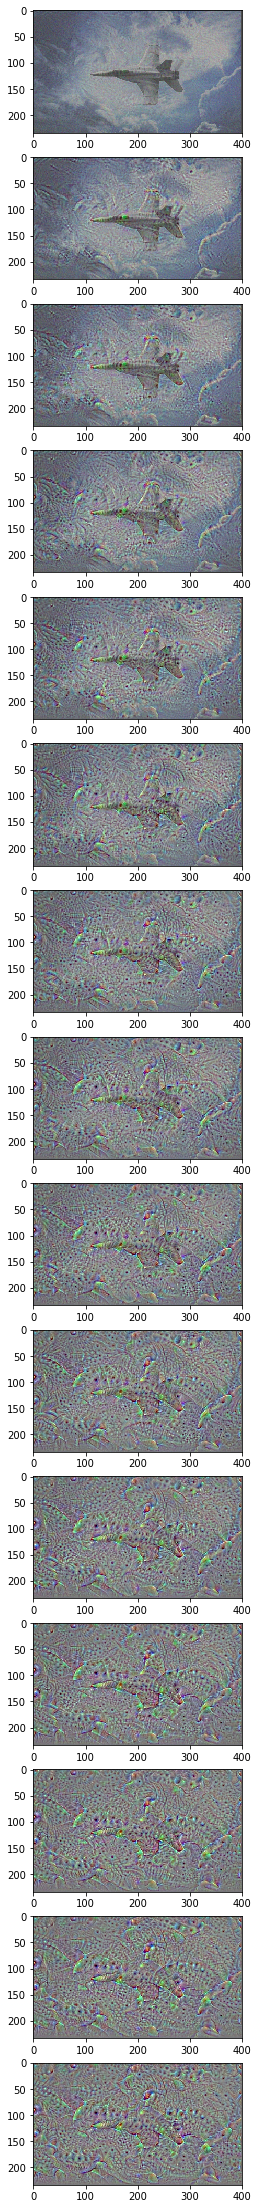

In [93]:
%%time
import glob
import cv2
import numpy as np


img_list2, resize_img_list2 = generate_deepdream_random_resize('block5_conv3', iteration_number=15, step=0.05, resize_number=3)

image_path = 'Results/noise/'

start_index = 0
end_index = 15

plt.figure(figsize=(500,40))
for i in range(start_index, end_index):
    filename = ''
    index = int(np.floor(i/10))
#     filename += 'image-' + str(chr(index+ord('a'))) + '-' + str(i%10)
    
    saved_image_filename = 'image-' + str(chr(index+ord('a'))) + '-' + str(i%10) + '.jpg'
    cv2.imwrite(image_path+saved_image_filename, img_list2[i])
    plt.subplot(end_index-start_index, 1, i-start_index+1)
    plt.imshow(img_list2[i])

In [94]:
import glob
def generate_video_from_images():
    img_array = list()
    image_path = 'Results/noise/*.jpg'
    filename_array = glob.glob(image_path)
    filename_array = sorted(filename_array)
    size = tuple()
    for filename in filename_array:
        img = cv2.imread(filename)
        print(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
        
    video_path = 'Results/'
    out = cv2.VideoWriter(video_path+'deepdream_noise.avi',cv2.VideoWriter_fourcc(*'MJPG'), 3, size)
     
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print('done')

In [95]:
generate_video_from_images()

Results/noise\image-a-0.jpg
Results/noise\image-a-1.jpg
Results/noise\image-a-2.jpg
Results/noise\image-a-3.jpg
Results/noise\image-a-4.jpg
Results/noise\image-a-5.jpg
Results/noise\image-a-6.jpg
Results/noise\image-a-7.jpg
Results/noise\image-a-8.jpg
Results/noise\image-a-9.jpg
Results/noise\image-b-0.jpg
Results/noise\image-b-1.jpg
Results/noise\image-b-2.jpg
Results/noise\image-b-3.jpg
Results/noise\image-b-4.jpg
done


We saved our pictures in Results/noise/ and we also made a video to show the transformation saved at Results/

In [96]:
filename = ''
i = 31
index = int(np.floor(i/10))

print(index)
print(chr(index+ord('a')))
print(i%10)

3
d
1


This is the result after we add noise to it. We cannot see if there are too much differences from non-noise one. We decided to compare them statiscally using Structural Similarity.

In [97]:
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [98]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=True)
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()

In [99]:
non_noise = cv2.imread("Results/Nonnoise/image-b-4.jpg")
noise = cv2.imread('Results/noise/image-b-4.jpg')

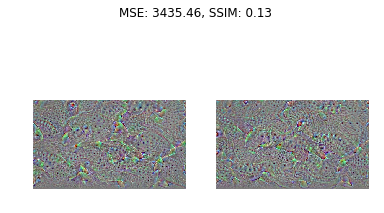

In [100]:
compare_images(non_noise, noise, 'Non-Noise vs Noise')

The image on the left is non-noise one and the image on the right is noise one. We calculate MSE and SSIM, even though from statiscal data, we see they are totally different. However we can still see the bird in the background and the aircraft becomes something that's similar to a bird. However, the non-noise one has a better and clear shape of bird, especiall at the head of the aircraft, non-noise one transforms the aircraft to a bird better. For watching the transformation clearly, there are pictures and video in folder Results/